Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Sedykh Ivan"
COLLABORATORS = ""

---

In [1]:
import numpy as np
import math

In [41]:
TEST = True

# Уравнение теплопроводности

Начально-краевая задача для уравнения теплопроводности с постоянным коэффициентом в общем виде можно записать следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} + f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника. 

## Явная схема

Запишем разностное уравнение явной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} + f_i^k,$$
где $\tau$ и $h$ - шаги по времени и пространству, $y_i^k$ - значение приближённого решения в точке $(i, k)$ сетки, $f_i^k$ - значение функции источника в той же точке сетки. 

Аппроксимируем начальное и граничные условия:
$$
\begin{array}{l}
y_i^0 = u_0(x_i), \; \forall i = \overline{0, N},\\
y_0^k = \mu_1(t_k), \\
y_N^k = \mu_2(t_k), \; \forall k > 0.
\end{array}$$

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Обратите внимание, что 
$$\exists \lim\limits_{t \rightarrow \infty} u(x, t) = u_\infty (x).$$
поэтому расчёт в какой-то момент следует остановить (считать до установления).

Во время проведения расчетов помните о том, что явная схема *условно* устойчива.

In [48]:
def put_bounds(a, bound1, bound2, t):
   a[0] = bound1(t)
   a[-1] = bound2(t)
   return a


def heat_expl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3, rethist=False):
   """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with an explicit scheme.

   Parameters
   ----------
   init : callable
      Initial condition
   bound1 : callable
      Boundary condition for x = 0
   bound2 : callable
      Boundary condition for x = lx
   alpha : float
      Thermal diffusivity
   h : float
      Spatial step
   tau : float
      Time step
   tol : float, optional
      Target tolerance.
      Stop iterations when the 2-norm of the difference between 
      solution on this time step and the next is less the tol.
      
   Returns
   -------
   t_end : ndarray, shape (n,)
      End time of calculation
   u_end : ndarray, shape (N,)
      Limit u_∞(x) (See above)
   """
   Nx = math.floor(lx / h) + 1
   x_grid, h = np.linspace(0, lx, Nx, retstep=True)

   if 2*alpha * tau / h**2 > 1:
      raise ValueError("Currant conditions broken")

   # x_grid = np.arange(0, lx + 1e-8, h)
   
   n = len(x_grid)
   init = np.vectorize(init)

   # init layer 0 
   t = 0
   y = init(x_grid)
   y = put_bounds(y, bound1, bound2, t)
   history = y

   # make step
   while True:
      t += tau
      y_new = np.zeros_like(y)
      y_new = put_bounds(y_new, bound1, bound2, t)
      for j in range(1, n-1):
         y_new[j] = y[j] + tau * (alpha * (y[j-1] - 2*y[j] + y[j+1]) / h**2)

      history = np.vstack([history, y])
      if np.linalg.norm(y - y_new) < tol:
         break
      else:
         y = y_new

   if rethist:
      return t, y_new, history

   return t, y_new

Протестируйте Вашу функцию.

In [49]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_expl(lambda x: 0., lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005) 
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. Для этого для каждой переменной ($t$ или $x$):

1. Сделайте несколько расчётов для разных значений шага (например, $h_0, \; 2 h_0, \; 4 h_0$).
2. В один и тот же момент времени $t_1$ найдите ошибку полученных решений. Для этого либо возьмите аналитическое решение задачи, либо сравните результат в конечный момент времени, например, с решением в момент времени $0.99 t_1$. Обратите внимание, что имеющуюся функцию `heat_expl` надо немного модифицировать.
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной.

Sanity-check

Посмотрю глазами не фигню ли я сделал вообще.

Ну вроде стрежень потихоньку остужается -- похоже на правду.

In [50]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,4)

u.shape=(72, 32)


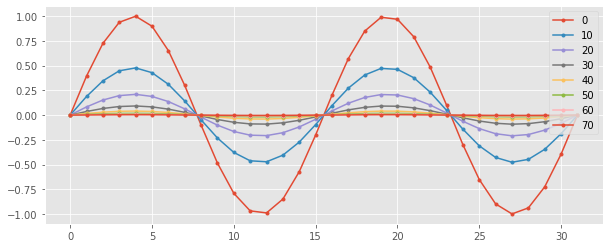

In [51]:
def plot_solution(u, step = 10, **kwargs):
    for i in range(0, len(u), step):
        plt.plot(u[i], label=i, **kwargs)
    plt.legend() 


t_1, u_1, u = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005, rethist=True) 

print(f"{u.shape=}")

plot_solution(u, marker='.', linestyle='-')

Согласно Википедии, общее решение для 0 граничных условие задается так:
$$
u(x,\;t)=\sum\limits_{n=1}^\infty \left(\dfrac{2}{l}\int\limits_0^l \varphi(\xi)\sin\left(\dfrac{\pi n}{l}\xi\right)\,d\xi\right)\sin\left(\dfrac{\pi n}{l}x\right)\exp\left(-a^2\left(\dfrac{\pi n}{l}\right)^2 t\right)
$$
где $\varphi(\xi) = u(x, 0)$

Захардкодим решение для 2 теста.

In [52]:
from scipy.integrate import quad_vec

def true_solution(h, t, u0, l, a, n_terms=10):
    Nx = math.floor(l / h) + 1
    x, h = np.linspace(0, l, Nx, retstep=True) # grid
    n = np.arange(1, n_terms)

    def f(xi, n): #  underintegral func
        return u0(xi) * np.sin(np.pi * n * xi / l)

    Bn = quad_vec(lambda xi: f(xi, n), 0, l)[0]

    u = 2/l * Bn[:, None] * np.sin(np.pi * n[:, None] * x[None:] / l)\
         * np.exp(-a * (np.pi * n[:, None] / l)**2 * t)

    u = np.sum(u, axis=0)
    return u

In [53]:
u_true = np.vstack([
        true_solution(
        h=0.1,
        t=t,
        u0 = lambda x: np.sin(4.*x),
        l = np.pi,
        a = 1.,
        n_terms=50
        ) for t in np.linspace(0, t_1, num=u.shape[0])
    ])

u_true.shape

(72, 32)

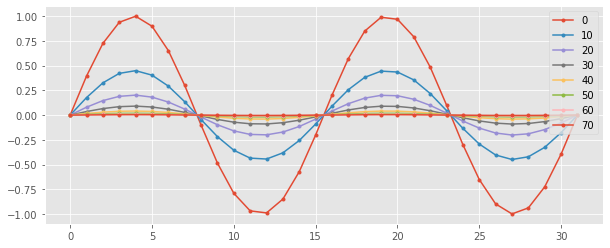

In [54]:
plot_solution(u_true, marker='.', linestyle='-')

In [78]:
def error(u, u_true):
    diff = (u_true - u)
    # diff = (u_true - u) / (u_true + 1e-10)#[50, None]
    # return np.linalg.norm(diff, axis=0, ord=1).mean()
    return np.abs(diff).mean()

def check_expl_x():
    from tqdm import tqdm

    h_expl_error_dict = {}

    # hs = [0.4, 0.2, 0.1]
    # hs = [0.4, 0.3, 0.2, 0.15, 0.1]
    hs = [0.04 * 2**i for i in range(4)]
    # hs = np.linspace(0.1, 1, num=20)

    pbar = tqdm(hs)
    for h in pbar:
        pbar.set_description(f"{h=:.4f}")

        # get numeric solution
        t_1, u_1, u = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                        alpha=1., lx=np.pi, h=h, tau=0.0005, rethist=True) 
        # get true solution
        u_true = np.vstack([
            true_solution(
            h=h,
            t=t,
            u0 = lambda x: np.sin(4.*x),
            l = np.pi,
            a = 1.,
            n_terms=50
            ) for t in np.linspace(0, t_1, num=u.shape[0])
        ])

        h_expl_error_dict[h] = error(u, u_true)

    return h_expl_error_dict

h=0.3200: 100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


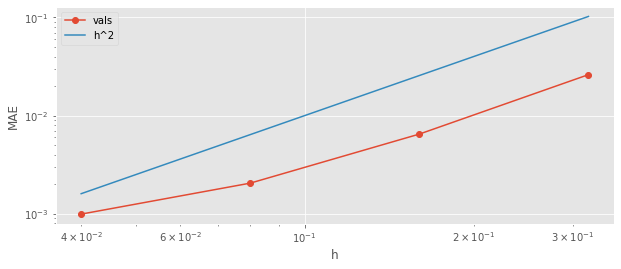

In [79]:
if TEST:
    h_expl_error_dict = check_expl_x()

    plt.plot(*np.array(list(h_expl_error_dict.items())).T, 'o-', label='vals')

    hs = np.array(list(h_expl_error_dict.items())).T[0]
    plt.plot(hs, hs**2, label='h^2')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('h')
    plt.ylabel('MAE');
    plt.legend();

Супер, прямые имеют одинаковый наклон, значит степени сходятся.

In [80]:
def check_expl_tau():
    from tqdm import tqdm

    expl_error_dict = {}

    # hs = [0.4, 0.2, 0.1]
    # hs = [0.4, 0.3, 0.2, 0.15, 0.1]
    taus = np.linspace(0.0005, 0.005, num=20)

    pbar = tqdm(taus)
    for tau in pbar:
        pbar.set_description(f"{tau=:.4f}")

        # get numeric solution
        t_1, u_1, u = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                        alpha=1., lx=np.pi, h=0.1, tau=tau, rethist=True) 
        # get true solution
        u_true = np.vstack([
            true_solution(
                h=0.1,
                t=t,
                u0 = lambda x: np.sin(4.*x),
                l = np.pi,
                a = 1.,
                n_terms=50
            ) for t in np.linspace(0, t_1, num=u.shape[0])
        ])

        expl_error_dict[tau] = error(u, u_true)

    return expl_error_dict

tau=0.0050: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


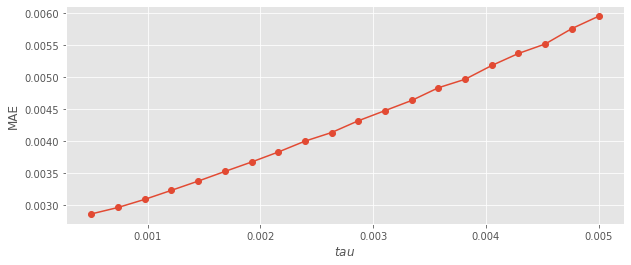

In [81]:
if TEST:
    expl_error_dict = check_expl_tau()

    plt.plot(*np.array(list(expl_error_dict.items())).T, 'o-')

    plt.xlabel('$tau$')
    plt.ylabel('MAE');

ну тут невооруженным глазом видна линейная зависимость, прям как на бумажке.

## Неявная схема 

Запишем разностное уравнение неявной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2} + f_i^{k+1}.$$

Аппроксимировать начальное и граничные условия будем так же, как в случае явной схемы.

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Для решения системы линейных уравнений используйте встроенные функции `scipy`.

$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2}$$
$$\lambda = \dfrac{\alpha \tau}{h^2}$$
$$y_i^{k+1} - y_i^{k} = \lambda (y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1})$$

$$-\lambda y_{i+1}^{k+1} +(1+ 2\lambda) y_i^{k+1} -\lambda y_{i-1}^{k+1} = y_i^{k}$$

In [84]:
from scipy.linalg import solve_banded


def make_step(y, bound1, bound2, t, lam):
   n = len(y)
   ab = np.zeros(shape=(3, n-2))
   ab[0, 1:] = -lam #  upper diag
   ab[1] = 1 + 2*lam #  main diag
   ab[2, :-1] = -lam #  lower diag

   b = np.copy(y[1: -1])
   b[0] += lam * bound1(t)
   b[-1] += lam * bound2(t)

   y_new = np.zeros(shape=n)
   y_new[1: -1] = solve_banded(l_and_u=(1,1), ab=ab, b=b)
   y_new[0] = bound1(t)
   y_new[-1] = bound2(t)

   return y_new

def heat_impl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3, rethist=False):
   """ Solve heat equation u_t = a*u_xx for x in (0; lx) with implicit scheme

      Parameters
      ----------
      init : callable
         Initial condition
      bound1 : callable
         Boundary condition for x = 0
      bound2 : callable
         Boundary condition for x = lx
      alpha : float, optional
         Thermal diffusivity
      h : float
         Spatial step
      tau : float
         Time step
      tol : float, optional
         Target tolerance.
         Stop iterations when the 2-norm of the difference between 
         solution on this time step and the next is less the tol.
         
      Returns
      -------
      t_end : ndarray, shape (n,)
         End time of calculation
      u_end : ndarray, shape (N,)
         Limit u_∞(x) (See above)
   """

    
   # x_grid = np.arange(0, lx + 1e-5, h) #  to include left bound
   Nx = math.floor(lx / h) + 1
   x_grid, h = np.linspace(0, lx, Nx, retstep=True)
   
   n = len(x_grid)
   init = np.vectorize(init)

   lam = alpha * tau / h**2

   # init layer 0 
   t = 0
   y = init(x_grid)
   y = put_bounds(y, bound1, bound2, t)
   history = y

   # make step
   while True:
      t += tau
      y_new = make_step(y, bound1, bound2, t, lam)

      if np.linalg.norm(y - y_new) < 0.1*tol: #  почему-то ассерт не проходит иначе
         break
      else:
         y = y_new
         history = np.vstack([history, y])

   if rethist:
      return t, y_new, history
   return t, y_new

Протестируйте Вашу функцию.

In [85]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_impl(lambda x: 0., lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005) 
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. (см. выше)

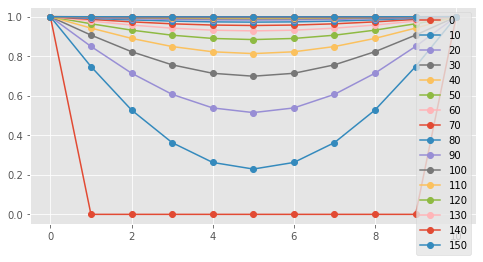

In [86]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(8, 4))

t_0, u_0, u = heat_impl(lambda x: 0., lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005, rethist=True) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

for i in range(0, len(u), 10):
    plt.plot(u[i], 'o-', label=i)

plt.legend()

Решение получается более гладкое как будто -- более похоже на то что в жизни.

In [93]:
def check_impl_x():
    from tqdm import tqdm

    error_dict = {}

    # hs = [0.4, 0.2, 0.1]
    # hs = [0.4, 0.3, 0.2, 0.15, 0.1]
    # hs = np.linspace(0.1, 1, num=20)
    hs = [0.02 * 2**i for i in range(5)]

    pbar = tqdm(hs)
    for h in pbar:
        pbar.set_description(f"{h=:.4f}")

        # get numeric solution
        t_1, u_1, u = heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                        alpha=1., lx=np.pi, h=h, tau=0.002, rethist=True) 
        # get true solution
        u_true = np.vstack([
            true_solution(
            h=h,
            t=t,
            u0 = lambda x: np.sin(4.*x),
            l = np.pi,
            a = 1.,
            n_terms=50
            ) for t in np.linspace(0, t_1, num=u.shape[0])
        ])

        error_dict[h] = error(u, u_true)

    return error_dict

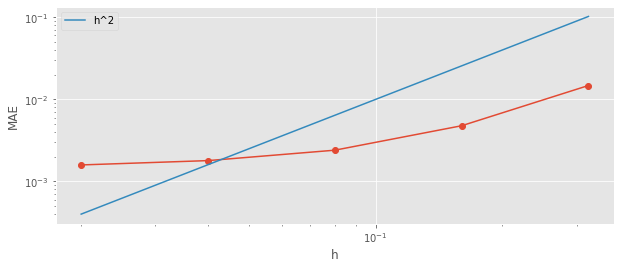

In [97]:
if TEST:
    h_impl_error_dict = check_impl_x()

    plt.plot(*np.array(list(h_impl_error_dict.items())).T, 'o-')

    hs = np.array(list(h_impl_error_dict.items())).T[0]
    plt.plot(hs, hs**2, label='h^2')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('h')
    plt.ylabel('MAE');
    plt.legend();

Ну как-то так.

In [98]:
def check_impl_tau():
    from tqdm import tqdm

    error_dict = {}

    taus = np.linspace(0.0005, 0.005, num=10)

    pbar = tqdm(taus)
    for tau in pbar:
        pbar.set_description(f"{tau=:.4f}")

        # get numeric solution
        t_1, u_1, u = heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                        alpha=1., lx=np.pi, h=0.1, tau=tau, rethist=True) 
        # get true solution
        u_true = np.vstack([
            true_solution(
                h=0.1,
                t=t,
                u0 = lambda x: np.sin(4.*x),
                l = np.pi,
                a = 1.,
                n_terms=50
            ) for t in np.linspace(0, t_1, num=u.shape[0])
        ])

        error_dict[tau] = error(u, u_true)

    return error_dict

tau=0.0050: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


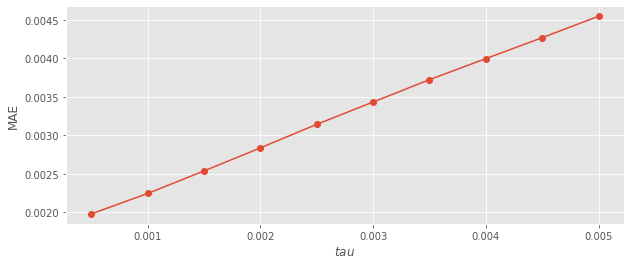

In [99]:
if TEST:
    error_dict = check_impl_tau()

    plt.plot(*np.array(list(error_dict.items())).T, 'o-')

    plt.xlabel('$tau$')
    plt.ylabel('MAE');

ну вот, хорошая линейная зависимость, все по теории.